In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect,func

In [4]:
# Path to the sqlite db
database_path = "./Resources/hawaii.sqlite"

# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")



In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#Inspect content for column names and type

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])    
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date = recent_date[0]
recent_date

'2017-08-23'

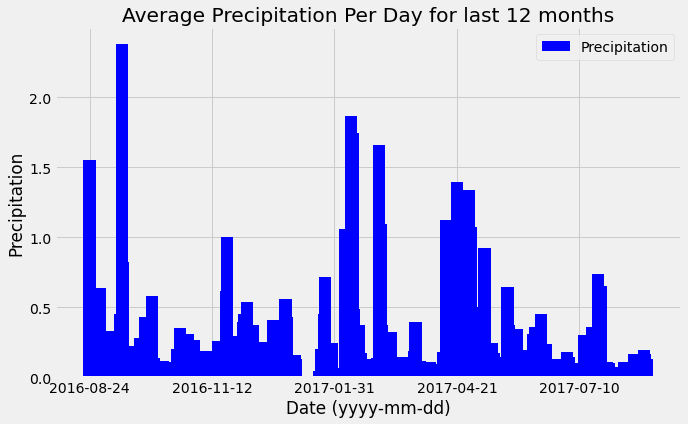

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#---------------------------------------------------------------
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Assign the dates for search query

latest_date=dt.datetime.strptime(recent_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

######-----Please note an average function is used for each date------######

results = session.query(Measurement.date,func.avg(Measurement.prcp)).\
      filter(Measurement.date < latest_date).\
      filter(Measurement.date > year_back).\
        order_by(Measurement.date).\
        group_by(Measurement.date).\
        all()


# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(results, columns = ["Date", "Precipitation"])
precip_df = precip_df.sort_values(["Date"], ascending=True)
precip_df = precip_df.set_index("Date")

#------------------------------------------------------------
x_data = precip_df.index.tolist()
y_data = precip_df['Precipitation'].tolist()

plt.figure(figsize=(10,6))
plt.bar(x_data,y_data,width = 8 ,color='b', alpha=1, align="center",label='Precipitation')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=True,      
    top=False,         
    labelbottom=True) 

major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)
plt.title(f"Average Precipitation Per Day for last 12 months")
plt.xlabel("Date (yyyy-mm-dd)")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset

session.query(Station.station).distinct().count()


9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
Actve_Stns = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
Actve_Stns

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temp_results=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station==Actve_Stns[0][0]).all()
temp_results


[(54.0, 85.0, 71.66378066378067)]

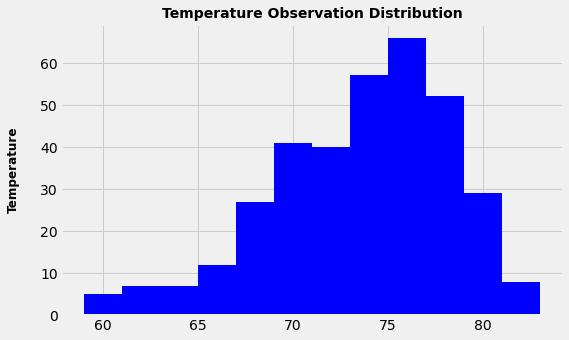

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).\
             filter(Measurement.station==Actve_Stns[0][0]).first()

latest_date=dt.datetime.strptime(recent_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=365)

results_temp=session.query(Measurement.tobs).\
             filter(Measurement.station==Actve_Stns[0][0]).\
             filter(Measurement.date>=year_back).all()

df_results=pd.DataFrame(results_temp)

#Plotting Histogram
hist_graph = df_results['tobs'].hist(bins=12,figsize=(8,5), color='b', zorder=2)

# Set title
hist_graph.set_title("Temperature Observation Distribution",weight='bold', size=14)

# Set y-axis label
hist_graph.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

# Set x-axis label
hist_graph.set_ylabel("Temperature", labelpad=20, weight='bold', size=12)

plt.show()

# Close session

In [17]:
# Close Session
session.close()